/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


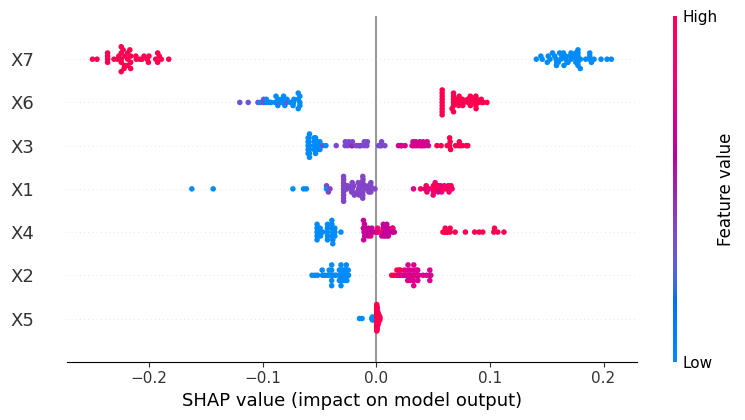

<Figure size 2500x2500 with 0 Axes>

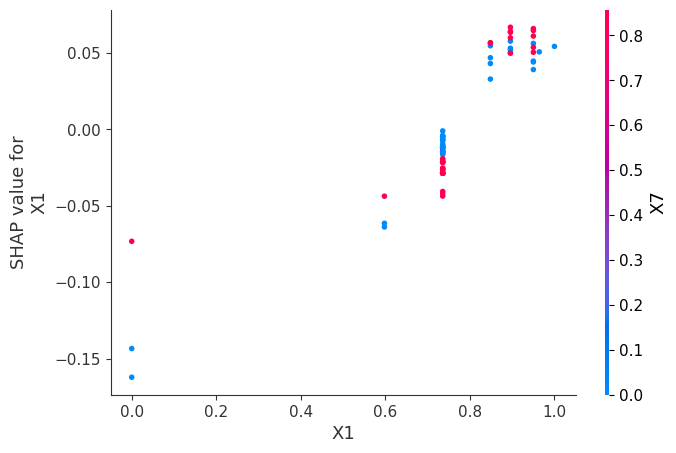

<Figure size 2500x2500 with 0 Axes>

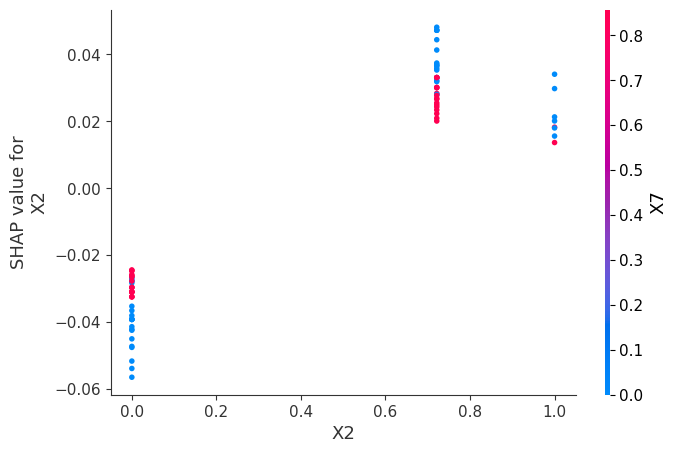

<Figure size 2500x2500 with 0 Axes>

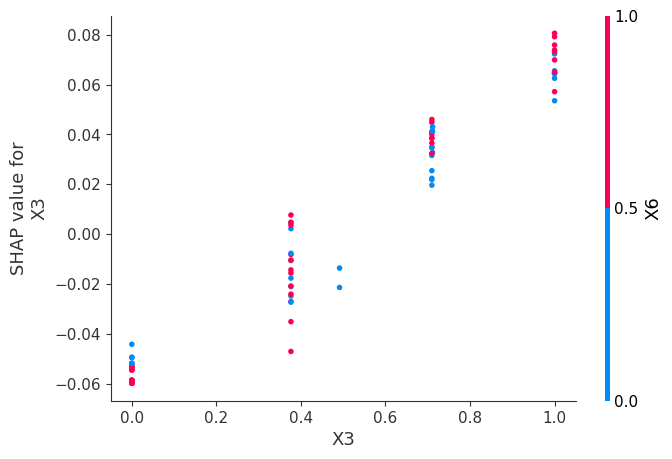

<Figure size 2500x2500 with 0 Axes>

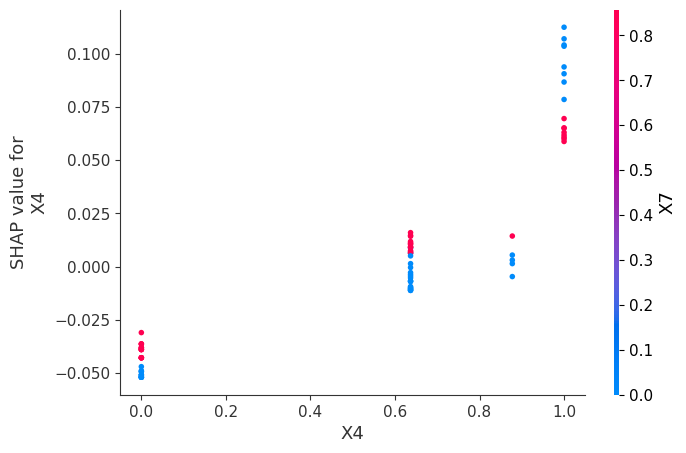

<Figure size 2500x2500 with 0 Axes>

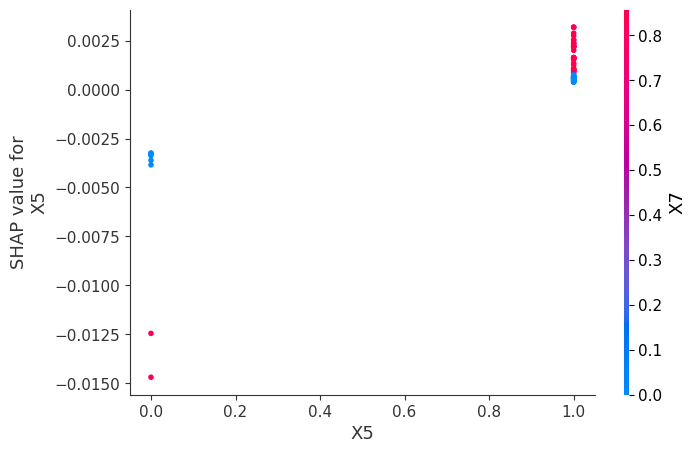

<Figure size 2500x2500 with 0 Axes>

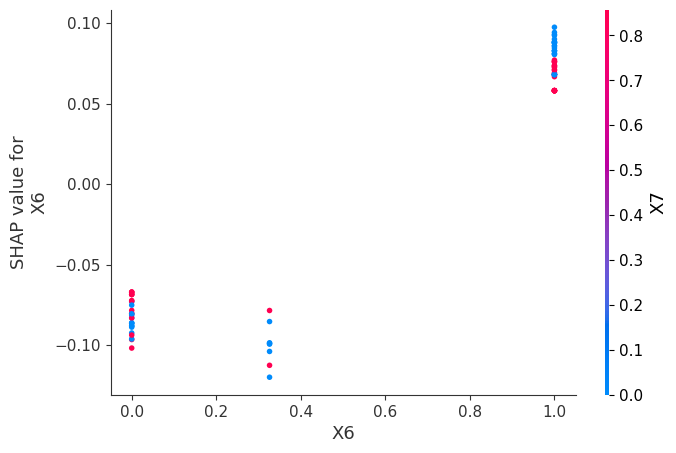

<Figure size 2500x2500 with 0 Axes>

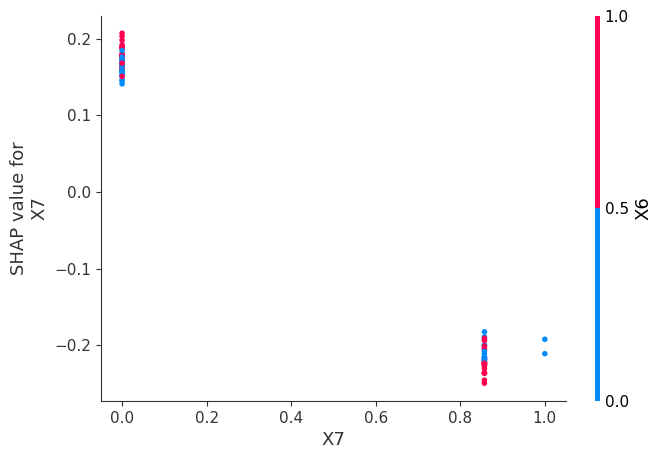

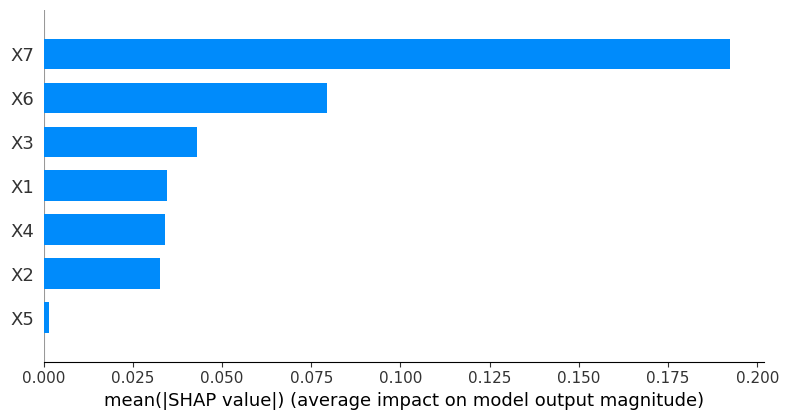

In [ ]:
import pandas as pd
import numpy as np
import os
import joblib
import shap
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from scipy.stats import linregress

# Load datasets
train_df = pd.read_excel("Train.xlsx")
test_df = pd.read_excel("Test.xlsx")

# Splitting data into features and target
X_train = train_df.drop(columns='Y')
y_train = train_df['Y']
X_test = test_df.drop(columns='Y')
y_test = test_df['Y']

# Define a function to compute performance metrics
def compute_metrics(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'MBE': np.mean(y_pred - y_true),
    }

# Define function to compute additional evaluation metrics
def compute_additional_metrics(y_true, y_pred):
    residuals = y_true - y_pred
    slope, intercept, _, _, _ = linregress(y_true, y_pred)
    si = np.sqrt(np.mean((residuals - residuals.mean())**2)) / y_true.std()
    willmott_index = 1 - (np.sum((y_pred - y_true)**2) / np.sum((np.abs(y_pred - y_true.mean()) + np.abs(y_true - y_true.mean()))**2))
    vaf = 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - y_true.mean())**2))
    pi = (1 - np.sqrt(np.mean((y_true - y_pred)**2)) / np.sqrt(np.mean((np.abs(y_true - y_true.mean()) + np.abs(y_pred - y_true.mean()))**2))) * 100
    return {'SI': si, 'Willmot Index': willmott_index, 'VAF': vaf, 'PI': pi}

# Define initial hyperparameters for Random Forest
initial_params = {
    'n_estimators': 10,
    'max_depth': 3,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
}

# Define Random Forest model with initial hyperparameters
initial_rf_model = RandomForestRegressor(random_state=42, **initial_params)

# Train the initial model
initial_rf_model.fit(X_train, y_train)

# Predictions and metrics for initial model on training and test data
initial_predictions_train = initial_rf_model.predict(X_train)
initial_predictions_test = initial_rf_model.predict(X_test)

# Predictions and metrics for initial model on test data
initial_train_metrics = compute_metrics(y_train, initial_predictions_train)
initial_test_metrics = compute_metrics(y_test, initial_predictions_test)

# Bayesian optimization setup for Random Forest
search_spaces = {
    'n_estimators': Integer(10, 600),
    'max_depth': Integer(3, 30),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20),
}

opt = BayesSearchCV(initial_rf_model, search_spaces, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
opt.fit(X_train, y_train)

# Best model after optimization
best_model = opt.best_estimator_

# Predictions and metrics for tuned model on training and test data
predictions_train = best_model.predict(X_train)
predictions_test = best_model.predict(X_test)
train_metrics = compute_metrics(y_train, predictions_train)
test_metrics = compute_metrics(y_test, predictions_test)

# Visualizing one of the trees from the Random Forest model
plt.figure(figsize=(20, 10))
plot_tree(best_model.estimators_[5], feature_names=X_train.columns, filled=True, max_depth=3)
plt.savefig("RF1_tree_visualization.png", dpi=600)
plt.close()

# Save model parameters, performance comparison, and hyperparameters to Excel
with pd.ExcelWriter("RF1_analysis.xlsx", engine='openpyxl') as writer:
    pd.DataFrame({'Actual': y_train, 'Predicted': predictions_train}).to_excel(writer, sheet_name='Train Predictions')
    pd.DataFrame({'Actual': y_test, 'Predicted': predictions_test}).to_excel(writer, sheet_name='Test Predictions')
    pd.DataFrame([best_model.get_params()]).to_excel(writer, sheet_name='Model Parameters')

    # Create a DataFrame to compare initial and tuned model performance for training and testing
    performance_comparison_df = pd.DataFrame({
        'Metric': ['R2', 'RMSE', 'MAE', 'MAPE', 'MBE'],
        'Initial Model Training': [initial_train_metrics[metric] for metric in ['R2', 'RMSE', 'MAE', 'MAPE', 'MBE']],
        'Tuned Model Training': [train_metrics[metric] for metric in ['R2', 'RMSE', 'MAE', 'MAPE', 'MBE']],
        'Initial Model Testing': [initial_test_metrics[metric] for metric in ['R2', 'RMSE', 'MAE', 'MAPE', 'MBE']],
        'Tuned Model Testing': [test_metrics[metric] for metric in ['R2', 'RMSE', 'MAE', 'MAPE', 'MBE']],
    })
    performance_comparison_df.to_excel(writer, sheet_name='Performance Comparison')

    # Create a DataFrame for initial and tuned hyperparameters
    hyperparameters_df = pd.DataFrame({
        'Parameter': list(initial_params.keys()),
        'Initial Value': list(initial_params.values()),
        'Tuned Value': [best_model.get_params()[param] for param in list(initial_params.keys())],
    })
    hyperparameters_df.to_excel(writer, sheet_name='Hyperparameters')

# SHAP values for feature importance
explainer = shap.Explainer(best_model)
shap_values = explainer.shap_values(X_train)

# Summary Plot - for each feature
plt.figure(figsize=(25, 25))
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)
plt.close()

# Dependence Plot - for each feature
for feature in X_train.columns:
    plt.figure(figsize=(25, 25))
    shap.dependence_plot(feature, shap_values, X_train, feature_names=X_train.columns)
    plt.close()

# Bar Plot - showing the average impact of each feature
plt.figure(figsize=(25, 25))
shap.summary_plot(shap_values, X_train, plot_type="bar")
plt.close()

# List of input combinations for evaluation
input_combinations = [
    ['X1'],
    ['X1', 'X2'],
    ['X1', 'X2', 'X3'],
    ['X1', 'X2', 'X3', 'X4'],
    ['X1', 'X2', 'X3', 'X4', 'X5'],
    ['X1', 'X2', 'X3', 'X4', 'X5', 'X6'],
    ['X1', 'X2', 'X3', 'X4', 'X5', 'X6','X7'],
    # Add more combinations as needed
]

# Dictionary to store evaluation results for each input combination
evaluation_results = {}

# Evaluate performance for each input combination
for input_features in input_combinations:
    # Subset features
    X_train_subset = X_train[input_features]
    X_test_subset = X_test[input_features]

    # Train the model on the subset of features
    best_model.fit(X_train_subset, y_train)

    # Predictions on training and testing data
    predictions_train_subset = best_model.predict(X_train_subset)
    predictions_test_subset = best_model.predict(X_test_subset)

    # Compute metrics for the subset
    metrics_train_subset = compute_metrics(y_train, predictions_train_subset)
    metrics_test_subset = compute_metrics(y_test, predictions_test_subset)

    # Compute additional metrics for the subset
    additional_metrics_train_subset = compute_additional_metrics(y_train, predictions_train_subset)
    additional_metrics_test_subset = compute_additional_metrics(y_test, predictions_test_subset)

    # Store results
    evaluation_results[str(input_features)] = {
        'Metrics Train': metrics_train_subset,
        'Metrics Test': metrics_test_subset,
        'Additional Metrics Train': additional_metrics_train_subset,
        'Additional Metrics Test': additional_metrics_test_subset
    }

# Plot comparison using bar charts for R2 and RMSE
r2_values_train = [evaluation_results[str(combo)]['Metrics Train']['R2'] for combo in input_combinations]
rmse_values_train = [evaluation_results[str(combo)]['Metrics Train']['RMSE'] for combo in input_combinations]
r2_values_test = [evaluation_results[str(combo)]['Metrics Test']['R2'] for combo in input_combinations]
rmse_values_test = [evaluation_results[str(combo)]['Metrics Test']['RMSE'] for combo in input_combinations]

# Append R2 and RMSE values for each input combination to the Excel sheet
with pd.ExcelWriter("RF1_analysis.xlsx", engine='openpyxl', mode='a') as writer:
    # Create a DataFrame for R2 and RMSE values
    performance_metrics_df = pd.DataFrame({
        'Input Combination': list(evaluation_results.keys()),
        'R2 Train': [evaluation_results[combo]['Metrics Train']['R2'] for combo in evaluation_results],
        'RMSE Train': [evaluation_results[combo]['Metrics Train']['RMSE'] for combo in evaluation_results],
        'R2 Test': [evaluation_results[combo]['Metrics Test']['R2'] for combo in evaluation_results],
        'RMSE Test': [evaluation_results[combo]['Metrics Test']['RMSE'] for combo in evaluation_results],
    })

    # Write the DataFrame to a new sheet
    performance_metrics_df.to_excel(writer, sheet_name='Input Combination Performance', index=False)

In [ ]:
pip install shap

In [ ]:
pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.1 MB/s eta 0:00:00
